In [3]:
# Import necessary libraries
# pip install pandas numpy matplotlib seaborn scikit-learn nltk wordcloud datasets

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.model_selection import train_test_split
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import warnings
from datasets import load_dataset

warnings.filterwarnings('ignore')

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jayden\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jayden\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Jayden\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

Dataset Information:
Shape: (2264, 4)

Sample of the dataset:
                                            Headline Sentiment
0  According to Gran , the company has no plans t...   neutral
1  For the last quarter of 2010 , Componenta 's n...  positive
2  In the third quarter of 2010 , net sales incre...  positive
3  Operating profit rose to EUR 13.1 mn from EUR ...  positive
4  Operating profit totalled EUR 21.1 mn , up fro...  positive

Missing values in each column:
Headline     0
Sentiment    0
dtype: int64

Sentiment Distribution:
Sentiment
neutral     1391
positive     570
negative     303
Name: count, dtype: int64


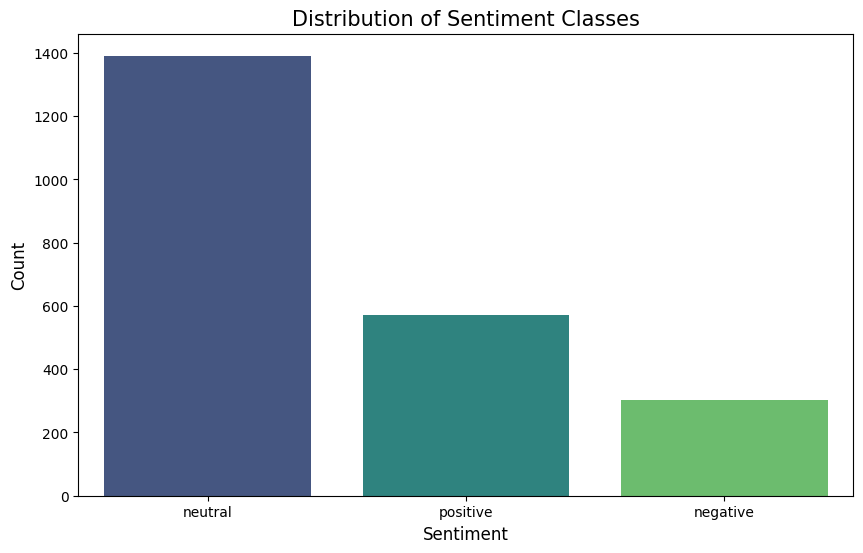

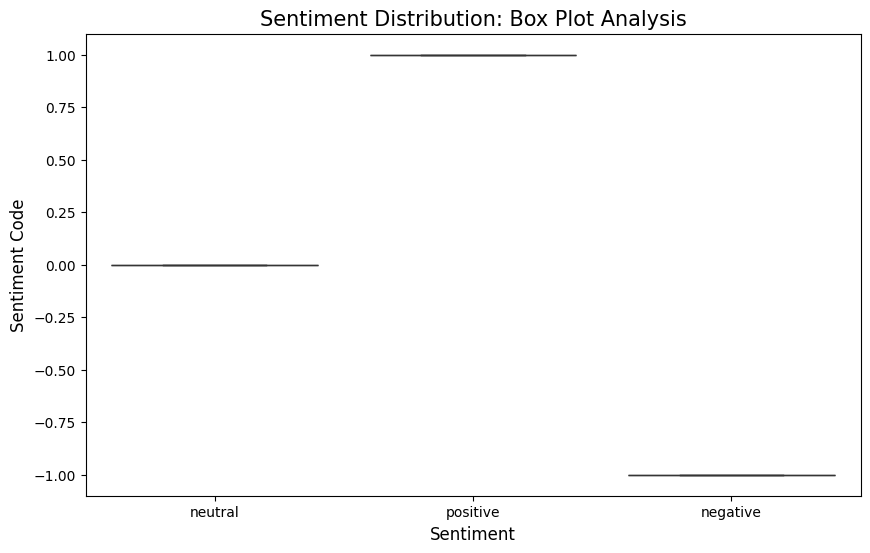

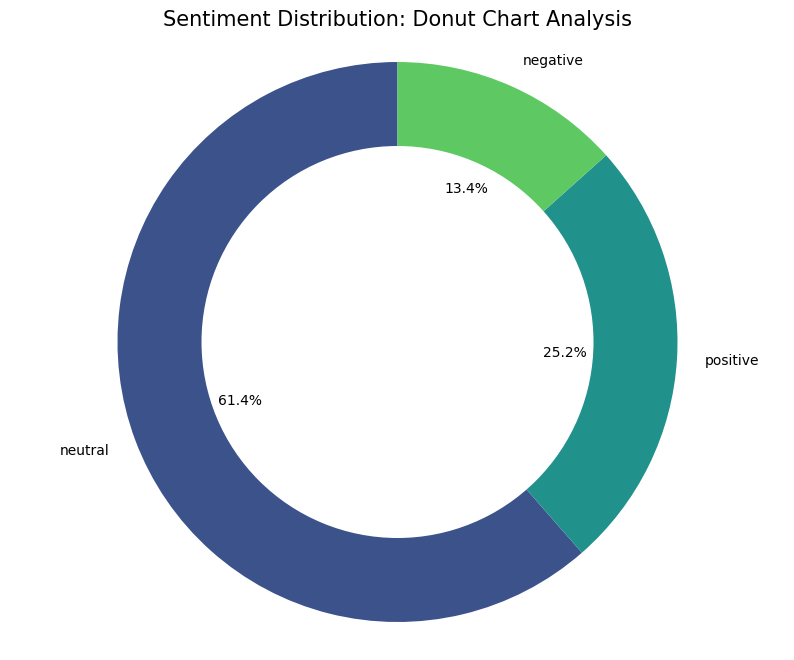

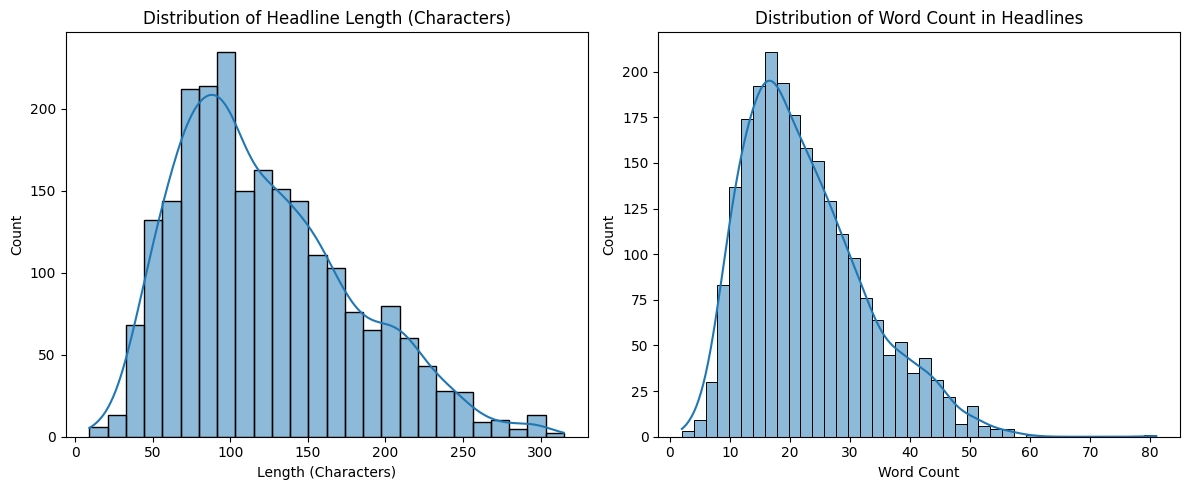

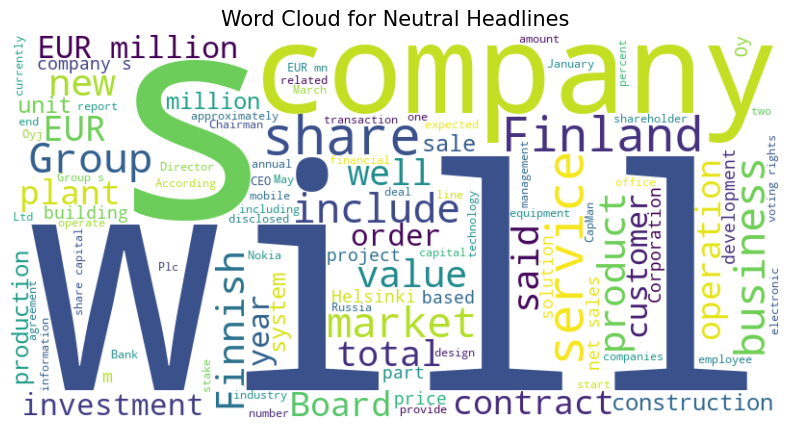

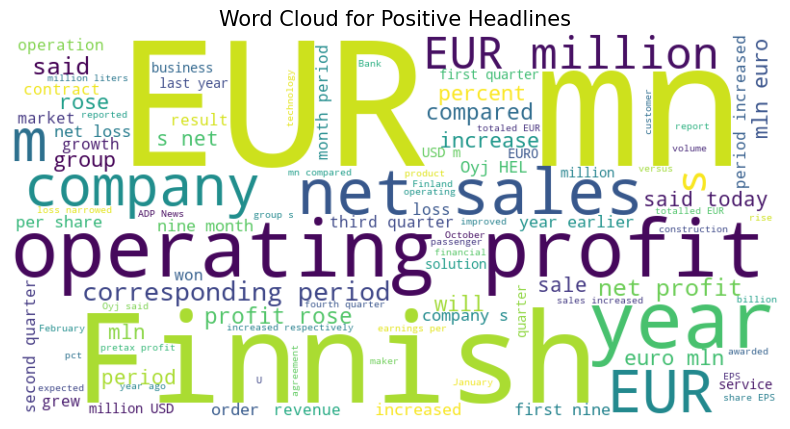

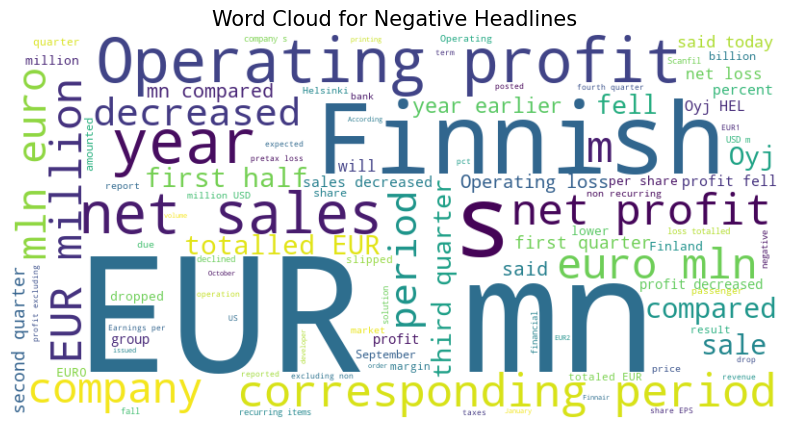

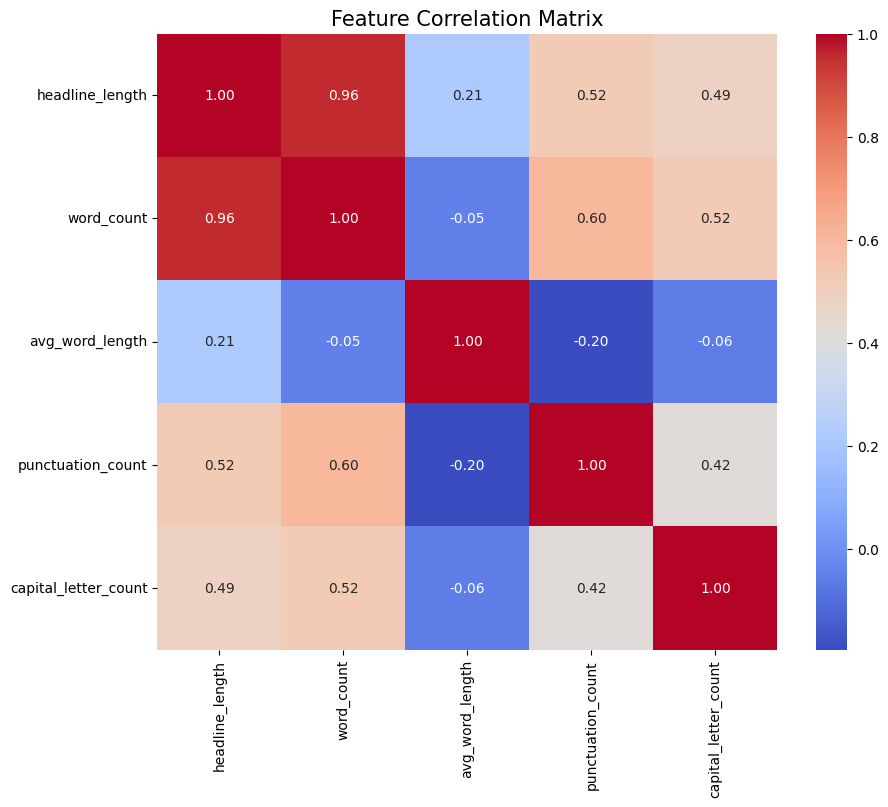

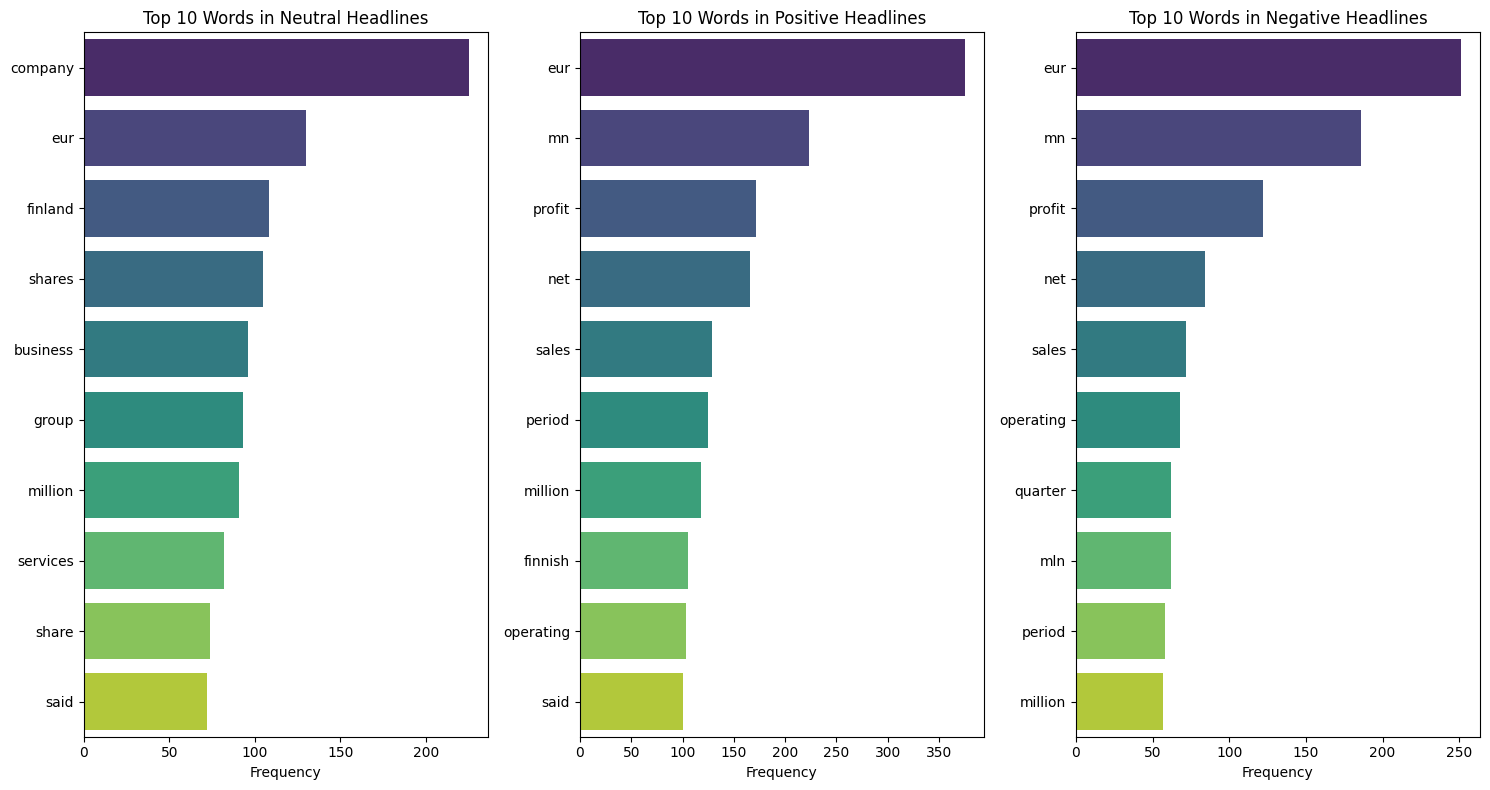


Training set shape: (1584,)
Testing set shape: (680,)

Training set sentiment distribution:
Sentiment
neutral     973
positive    399
negative    212
Name: count, dtype: int64

Testing set sentiment distribution:
Sentiment
neutral     418
positive    171
negative     91
Name: count, dtype: int64

Data processing and EDA completed. Files saved for model training.


In [ ]:
# Load the FinancialPhraseBank dataset
dataset = load_dataset("takala/financial_phrasebank", "sentences_allagree", trust_remote_code=True)

# Prepare the DataFrame
df = pd.DataFrame(dataset['train'])

# Map label integers to sentiment names
sentiment_map = {0: "negative", 1: "neutral", 2: "positive"}
df['Sentiment'] = df['label'].map(sentiment_map)
df['Headline'] = df['sentence']

# Display basic information about the dataset
print("Dataset Information:")
print(f"Shape: {df.shape}")
print("\nSample of the dataset:")
print(df[['Headline', 'Sentiment']].head())

# Check for missing values
print("\nMissing values in each column:")
print(df[['Headline', 'Sentiment']].isnull().sum())

# Analyze the distribution of sentiment classes
sentiment_counts = df['Sentiment'].value_counts()
print("\nSentiment Distribution:")
print(sentiment_counts)

# Visualize the sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Sentiment', data=df, palette='viridis')
plt.title('Distribution of Sentiment Classes', fontsize=15)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()
# Create a box plot for sentiment distribution
plt.figure(figsize=(10, 6))
df['Sentiment_Code'] = df['Sentiment'].map({'positive': 1, 'neutral': 0, 'negative': -1})
sns.boxplot(x='Sentiment', y='Sentiment_Code', data=df, palette='viridis')
plt.title('Sentiment Distribution: Box Plot Analysis', fontsize=15)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Sentiment Code', fontsize=12)
plt.show()

# Create a donut chart for sentiment distribution
plt.figure(figsize=(10, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', 
        startangle=90, colors=sns.color_palette('viridis', n_colors=len(sentiment_counts)))
plt.axis('equal')
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Sentiment Distribution: Donut Chart Analysis', fontsize=15)
plt.show()

# Text analysis - length of headlines
df['headline_length'] = df['Headline'].apply(len)
df['word_count'] = df['Headline'].apply(lambda x: len(word_tokenize(x)))

# Visualize the length distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['headline_length'], kde=True)
plt.title('Distribution of Headline Length (Characters)', fontsize=12)
plt.xlabel('Length (Characters)', fontsize=10)
plt.ylabel('Count', fontsize=10)

plt.subplot(1, 2, 2)
sns.histplot(df['word_count'], kde=True)
plt.title('Distribution of Word Count in Headlines', fontsize=12)
plt.xlabel('Word Count', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.tight_layout()
plt.show()

# Analyze the most common words in each sentiment category
stop_words = set(stopwords.words('english'))

def get_tokens_without_stopwords(text):
    tokens = word_tokenize(text.lower())
    return [word for word in tokens if word.isalpha() and word not in stop_words]

# Create a function to generate word clouds
def generate_wordcloud(text, title, filename):
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=15)
    plt.show()

# Generate word clouds for each sentiment
for sentiment in df['Sentiment'].unique():
    text = ' '.join(df[df['Sentiment'] == sentiment]['Headline'])
    generate_wordcloud(text, f'Word Cloud for {sentiment.capitalize()} Headlines', f'wordcloud_{sentiment}.png')

# Prepare data for correlation analysis
df['avg_word_length'] = df['Headline'].apply(lambda x: np.mean([len(word) for word in word_tokenize(x)]) if len(word_tokenize(x)) > 0 else 0)
df['punctuation_count'] = df['Headline'].apply(lambda x: sum(1 for char in x if char in '.,;:!?'))
df['capital_letter_count'] = df['Headline'].apply(lambda x: sum(1 for char in x if char.isupper()))

# Create a correlation matrix
corr_features = ['headline_length', 'word_count', 'avg_word_length', 'punctuation_count', 'capital_letter_count']
correlation_matrix = df[corr_features].corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix', fontsize=15)
plt.show()

# Analyze keyword frequency for each sentiment
sentiment_words = {}
for sentiment in df['Sentiment'].unique():
    words = []
    for headline in df[df['Sentiment'] == sentiment]['Headline']:
        tokens = get_tokens_without_stopwords(headline)
        words.extend(tokens)
    sentiment_words[sentiment] = Counter(words)

# Plot the top 10 most frequent words for each sentiment
plt.figure(figsize=(15, 8))
for i, sentiment in enumerate(df['Sentiment'].unique(), 1):
    plt.subplot(1, 3, i)
    top_words = sentiment_words[sentiment].most_common(10)
    words, counts = zip(*top_words)
    sns.barplot(x=list(counts), y=list(words), palette='viridis')
    plt.title(f'Top 10 Words in {sentiment.capitalize()} Headlines', fontsize=12)
    plt.xlabel('Frequency', fontsize=10)
plt.tight_layout()
plt.show()

# Data preparation for model training
X = df['Headline']
y = df['Sentiment']

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("\nTraining set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("\nTraining set sentiment distribution:")
print(y_train.value_counts())
print("\nTesting set sentiment distribution:")
print(y_test.value_counts())

# Save the processed data
train_df = pd.DataFrame({'Headline': X_train, 'Sentiment': y_train})
test_df = pd.DataFrame({'Headline': X_test, 'Sentiment': y_test})

train_df.to_csv('../dataset/financial_news_train.csv', index=False)
test_df.to_csv('../dataset/financial_news_test.csv', index=False)

print("\nData processing and EDA completed. Files saved for model training.")
